In [1]:
pip install --pre dgl-cu116 -f https://data.dgl.ai/wheels-test/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 6.0 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [2]:
import torch
try:
    import torch_geometric
except ModuleNotFoundError:
    TORCH = torch.__version__.split("+")[0]
    CUDA = "cu" + torch.version.cuda.replace(".","")
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
import torch_geometric #download torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 27.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=72a1df6829d280674394f59b82ccba80430c4c169727c3e816e9f15ebd24e573
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c6

In [3]:
import torch
import dgl
from dgl.data import CoraGraphDataset #Data 1
from dgl.data import RedditDataset #Data 2
#from dgl.data import PPIDataset #Data 3 (Not working)

from dgl.nn import SAGEConv

import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

import scipy
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
scipy.__version__

'1.7.3'

In [5]:
dgl.__version__

'1.0a230116'

In [6]:
torch.__version__

'1.13.1+cu116'

In [7]:
dataset1 = CoraGraphDataset(verbose=True)

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [8]:
#dataset2 = RedditDataset(self_loop=False, verbose=True) Too large

Finished data loading.
  NumNodes: 232965
  NumEdges: 114615892
  NumFeats: 602
  NumClasses: 41
  NumTrainingSamples: 153431
  NumValidationSamples: 23831
  NumTestSamples: 55703
Done loading data from cached files.


In [8]:
torch.cuda.is_available()

True

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [211]:
from torch_geometric.loader import NeighborLoader
from dgl.dataloading import DataLoader, NeighborSampler, MultiLayerFullNeighborSampler

sampler = NeighborSampler([10,100])
dataloader1 = DataLoader(
        dataset1[0], torch.arange(dataset1[0].num_nodes()).to(dataset1[0].device), sampler, device=device,
        batch_size=256, shuffle=False, drop_last=False,
        num_workers=0)

In [212]:
dataset1[0].ndata["train_mask"]

tensor([ True,  True,  True,  ..., False, False, False])

In [213]:
dataset1[0].ndata["val_mask"]

tensor([False, False, False,  ..., False, False, False])

In [214]:
for it, (input_nodes, output_nodes, blocks) in enumerate(dataloader1):
    print(blocks)

[Block(num_src_nodes=1779, num_dst_nodes=960, num_edges=4261), Block(num_src_nodes=960, num_dst_nodes=256, num_edges=1053)]
[Block(num_src_nodes=1820, num_dst_nodes=978, num_edges=4349), Block(num_src_nodes=978, num_dst_nodes=256, num_edges=1059)]
[Block(num_src_nodes=1798, num_dst_nodes=935, num_edges=4195), Block(num_src_nodes=935, num_dst_nodes=256, num_edges=996)]
[Block(num_src_nodes=1773, num_dst_nodes=882, num_edges=3922), Block(num_src_nodes=882, num_dst_nodes=256, num_edges=882)]
[Block(num_src_nodes=1775, num_dst_nodes=904, num_edges=4042), Block(num_src_nodes=904, num_dst_nodes=256, num_edges=986)]
[Block(num_src_nodes=1805, num_dst_nodes=950, num_edges=4177), Block(num_src_nodes=950, num_dst_nodes=256, num_edges=1041)]
[Block(num_src_nodes=1733, num_dst_nodes=933, num_edges=4218), Block(num_src_nodes=933, num_dst_nodes=256, num_edges=1182)]
[Block(num_src_nodes=1538, num_dst_nodes=841, num_edges=3753), Block(num_src_nodes=841, num_dst_nodes=256, num_edges=1209)]
[Block(num_

In [215]:
for input_nodes, output_nodes, blocks in dataloader1:
    print(blocks[1].dstdata["feat"].shape)
    #print(blocks[1].dstdata['feat'].shape)


torch.Size([256, 1433])
torch.Size([256, 1433])
torch.Size([256, 1433])
torch.Size([256, 1433])
torch.Size([256, 1433])
torch.Size([256, 1433])
torch.Size([256, 1433])
torch.Size([256, 1433])
torch.Size([256, 1433])
torch.Size([256, 1433])
torch.Size([148, 1433])


In [216]:
for batch_graphs in dataloader1:
    for i in batch_graphs:
        print(i[0])

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
Block(num_src_nodes=1785, num_dst_nodes=960, num_edges=4261)
tensor(256, device='cuda:0')
tensor(256, device='cuda:0')
Block(num_src_nodes=1825, num_dst_nodes=978, num_edges=4349)
tensor(512, device='cuda:0')
tensor(512, device='cuda:0')
Block(num_src_nodes=1805, num_dst_nodes=935, num_edges=4195)
tensor(768, device='cuda:0')
tensor(768, device='cuda:0')
Block(num_src_nodes=1781, num_dst_nodes=882, num_edges=3922)
tensor(1024, device='cuda:0')
tensor(1024, device='cuda:0')
Block(num_src_nodes=1763, num_dst_nodes=904, num_edges=4042)
tensor(1280, device='cuda:0')
tensor(1280, device='cuda:0')
Block(num_src_nodes=1816, num_dst_nodes=952, num_edges=4192)
tensor(1536, device='cuda:0')
tensor(1536, device='cuda:0')
Block(num_src_nodes=1743, num_dst_nodes=933, num_edges=4218)
tensor(1792, device='cuda:0')
tensor(1792, device='cuda:0')
Block(num_src_nodes=1547, num_dst_nodes=841, num_edges=3753)
tensor(2048, device='cuda:0')
tensor(2048, d

In [217]:
from dgl.dataloading.dataloader import batch_graphs
class SAGE(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()
        self.layers = nn.ModuleList()
        # two-layer GraphSAGE-mean
        self.layers.append(SAGEConv(in_size, hid_size, "mean"))
        self.layers.append(SAGEConv(hid_size, out_size, "mean"))
        self.dropout = nn.Dropout(0.5)

    def forward(self, blocks, x):
        h = x
        for l, (layer, block) in enumerate(zip(self.layers, blocks)):
            h = layer(block, h)
            if l != len(self.layers) - 1:
                h = F.relu(h)
                h = self.dropout(h)
        return h

# f1-micro
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        incorrect = torch.sum(indices != labels)
        
        return correct.item() / (correct.item() + 0.5 * incorrect.item())


def train(model, dataloader):
    # define train/val samples, loss function and optimizer
    loss_fcn = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)

    train_loss_list = []
    val_acc_list = []

    # training loop
    for epoch in range(200):
        model.train()
        val_acc = 0
        train_loss = 0

        for input_nodes, output_nodes, batch_graphs in dataloader:

            features = batch_graphs[0].srcdata['feat']
            labels = batch_graphs[1].dstdata['label']
            train_mask, val_mask = batch_graphs[1].dstdata["train_mask"], batch_graphs[1].dstdata["val_mask"]
            #in_size = features.shape[1] = 1433 # number of features
            #out_size = dataset1.num_classes  = 7 # number of classes

            logits = model(batch_graphs, features)
            loss = loss_fcn(logits[train_mask], labels[train_mask])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            val_acc += evaluate(batch_graphs, features, labels, val_mask, model)
            train_loss += loss.item()
            break

        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)

        print( "Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f} ".format( epoch, train_loss, val_acc ))
    return train_loss_list, val_acc_list

In [218]:
# model training
print("Training...")
model = SAGE(1433, 16, 7).to(device)
dataloader = dataloader1
train_loss_ouput , val_acc_output = train(model, dataloader)

Training...
Epoch 00000 | Loss 1.9581 | Accuracy 0.1440 
Epoch 00001 | Loss 1.9314 | Accuracy 0.2154 
Epoch 00002 | Loss 1.9007 | Accuracy 0.2687 
Epoch 00003 | Loss 1.8652 | Accuracy 0.2556 
Epoch 00004 | Loss 1.8213 | Accuracy 0.2687 
Epoch 00005 | Loss 1.7939 | Accuracy 0.2815 
Epoch 00006 | Loss 1.7393 | Accuracy 0.3776 
Epoch 00007 | Loss 1.7131 | Accuracy 0.4324 
Epoch 00008 | Loss 1.6763 | Accuracy 0.5409 
Epoch 00009 | Loss 1.6095 | Accuracy 0.6272 
Epoch 00010 | Loss 1.5791 | Accuracy 0.6667 
Epoch 00011 | Loss 1.5356 | Accuracy 0.7322 
Epoch 00012 | Loss 1.4716 | Accuracy 0.7459 
Epoch 00013 | Loss 1.4365 | Accuracy 0.7789 
Epoch 00014 | Loss 1.3604 | Accuracy 0.7853 
Epoch 00015 | Loss 1.3053 | Accuracy 0.8163 
Epoch 00016 | Loss 1.2745 | Accuracy 0.8103 
Epoch 00017 | Loss 1.2184 | Accuracy 0.8283 
Epoch 00018 | Loss 1.2139 | Accuracy 0.8223 
Epoch 00019 | Loss 1.1279 | Accuracy 0.8283 
Epoch 00020 | Loss 1.0486 | Accuracy 0.8283 
Epoch 00021 | Loss 1.0298 | Accuracy 0.8400

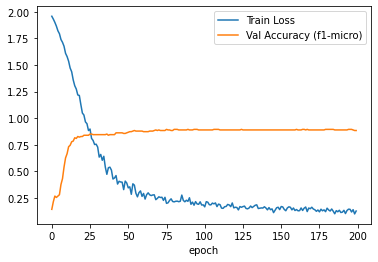

In [219]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(train_loss_ouput)
plt.plot(val_acc_output)
plt.legend(['Train Loss', 'Val Accuracy (f1-micro)'])
plt.xlabel('epoch')
plt.show()

In [220]:
import pandas as pd
df = pd.DataFrame([[2.2,'mini_batch', 'GS-GCN']
                ,[3.1,'full_batch', 'GS-GCN']
                ,[2.5, 'mini_batch', 'GS-mean']
                ,[3.5, 'full_batch','GS-mean']
                ,[3.1, 'mini_batch', 'GS-maxpool']
                ,[6.8, 'full_batch', 'GS-maxpool']
                ,[10.7, 'mini_batch', 'GS-lstm']
                ,[30.2, 'full_batch', 'GS-lstm']]
                ,columns=['time (sec)', 'train_type', 'model'])

In [221]:
df

,time (sec),train_type,model
0,2.2,mini_batch,GS-GCN
1,3.1,full_batch,GS-GCN
2,2.5,mini_batch,GS-mean
3,3.5,full_batch,GS-mean
4,3.1,mini_batch,GS-maxpool
5,6.8,full_batch,GS-maxpool
6,10.7,mini_batch,GS-lstm
7,30.2,full_batch,GS-lstm


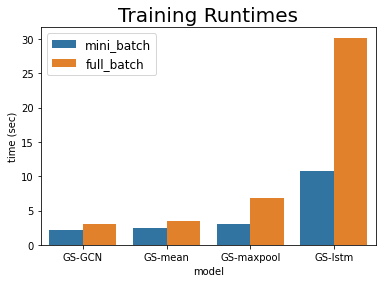

In [222]:
import seaborn as sns
#Train run time 
sns.barplot(data=df, x='model', y='time (sec)', hue = 'train_type') # default : dodge=True
plt.title('Training Runtimes', fontsize=20)
plt.legend(fontsize=12)
plt.show()

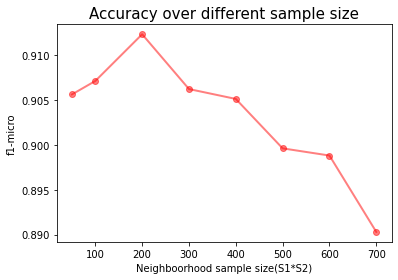

In [232]:
x= [50, 100, 200, 300, 400, 500, 600, 700]
y = [0.9056, 0.9071, 0.9123, 0.9062, 0.9051, 0.8996, 0.8988, 0.8903]
plt.plot(x, y, color='red', marker='o', alpha=0.5, linewidth=2)
 
plt.title("Accuracy over different sample size", fontsize=15)
plt.xlabel("Neighboorhood sample size(S1*S2)", fontsize=10)
plt.ylabel("f1-micro", fontsize=10)
plt.show()